Copyright 2019 Carsten Blank

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
%aimport lib_experimental_utils
%aimport lib_experiment_setups

In [3]:
import numpy as np
import lib_experimental_utils as lib
from lib_experimental_utils import FinishedExperiment, save
import lib_experiment_setups as expset

In [34]:
readout_swap = {}
id1 = expset.create_regular_experiment_and_then_simulation(backend_enum=expset.BackendEnum.IBMQX2, 
                                                           instead_general_weights_use_hadamard=False,
                                                           use_barriers=False, readout_swap=readout_swap,
                                                           no_experiment=False, dont_use_dask=False)

In [35]:
expset.get_ids()

['exp_sim_regular_20190929T193610Z',
 'exp_sim_regular_20190929T191722Z',
 'exp_sim_regular_20190929T114806Z',
 'exp_sim_regular_20190929T114714Z',
 'exp_sim_regular_20190929T114658Z']

In [36]:
loaded_data = expset.load_by_index(0, 'exp_sim_regular_')
loaded_data

In [37]:
experiment: FinishedExperiment = loaded_data[0]
simulation: FinishedExperiment = loaded_data[1]
experiment.backend_name

'ibmqx2'

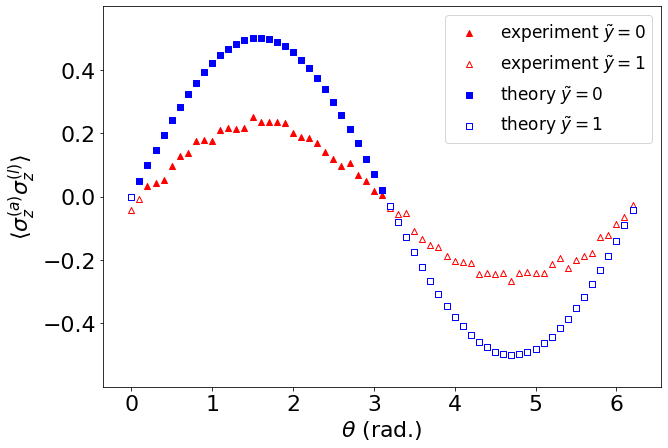

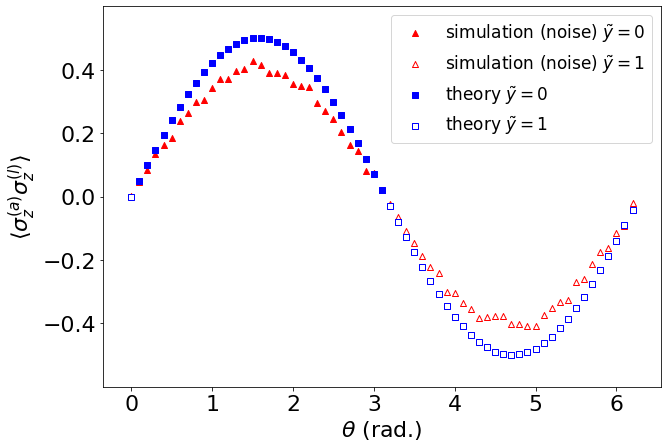

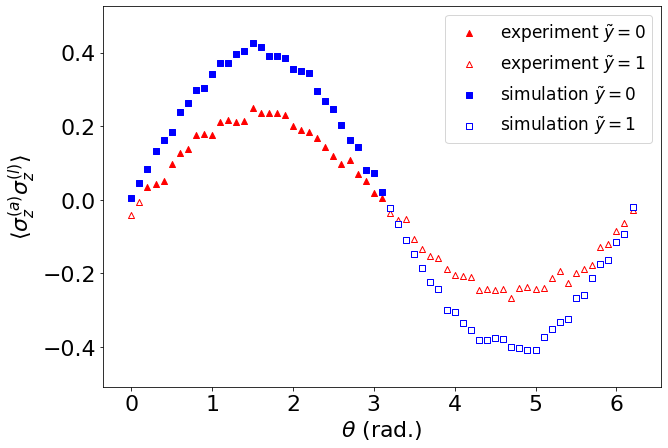

In [38]:
w_1 = 0.5
w_2 = 1 - w_1
theta = np.asarray(experiment.theta)
theory_classification = w_1 * np.sin(theta/2 + np.pi/4)**2 - w_2 * np.cos(theta/2 + np.pi/4)**2

experiment.show_plot(compare_classification=theory_classification, classification_label='experiment', compare_classification_label='theory')
simulation.show_plot(compare_classification=theory_classification, classification_label='simulation (noise)', compare_classification_label='theory')
experiment.show_plot(compare_classification=simulation.get_classification(), classification_label='experiment', compare_classification_label='simulation')


In [39]:
lib.save(directory="../../experiment_results", experiment=experiment, simulation=simulation)

INFO:lib_experimental_utils:Saving to ../../experiment_results/exp_sim_regular_20190929T193610Z.py
/home/carsten/Documents/github/Quantum-classifier-with-tailored-quantum-kernels---Supplemental/code/venv/lib/python3.6/site-packages/qiskit/providers/aer/noise/noise_model.py:565: DeprecationWarning: NoiseModel::as_dict() method is deprecated and will be removed after 0.3.Use '.to_dict()' instead
  deprecation("NoiseModel::as_dict() method is deprecated and will be removed after 0.3."


In [43]:
#simulation.parameters['device_properties']
